# Make-Moons Experiments (no `sklearn.datasets.make_moons`)

This notebook reproduces the full experimental pipeline requested:
- Generate Make-Moons dataset **without** `sklearn.datasets.make_moons` (custom implementation).
- Use train & test sets with 500 points each and default noise `0.2`. Also create two extra test sets with noise `0.1` and `0.3`.
- Standardize **after** the split using **train** statistics only.
- Validation split: 20% of the training set for model selection.
- Random seed: `1337`.

Models trained (all MLPs use **two hidden layers** with **4** and **6** neurons respectively):
1. MLP with early stopping (patience=50)
2. MLP with **L1** regularization (grid of λ). Report layer-wise sparsity and validation AUROC vs λ
3. MLP with **L2** regularization (tune penalty via validation)
4. Logistic Regression with polynomial features (degree 2 and 3)

- Decision boundary plots for each model (noise=0.2)
- Table of test accuracies across noise levels (0.1, 0.2, 0.3), with parameter counts
- ROC-AUC plots
- Add class imbalance (70:30) in the train set (keep test balanced) and report accuracy & AUROC; discuss



In [107]:
# Suppress library warnings
import warnings
warnings.filterwarnings("ignore")

# Cell: Imports, random seeds, and helper functions
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
plt.style.use('seaborn-v0_8-whitegrid')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random
import math
from typing import Tuple, Dict, List

# Reproducibility
SEED = 1337
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


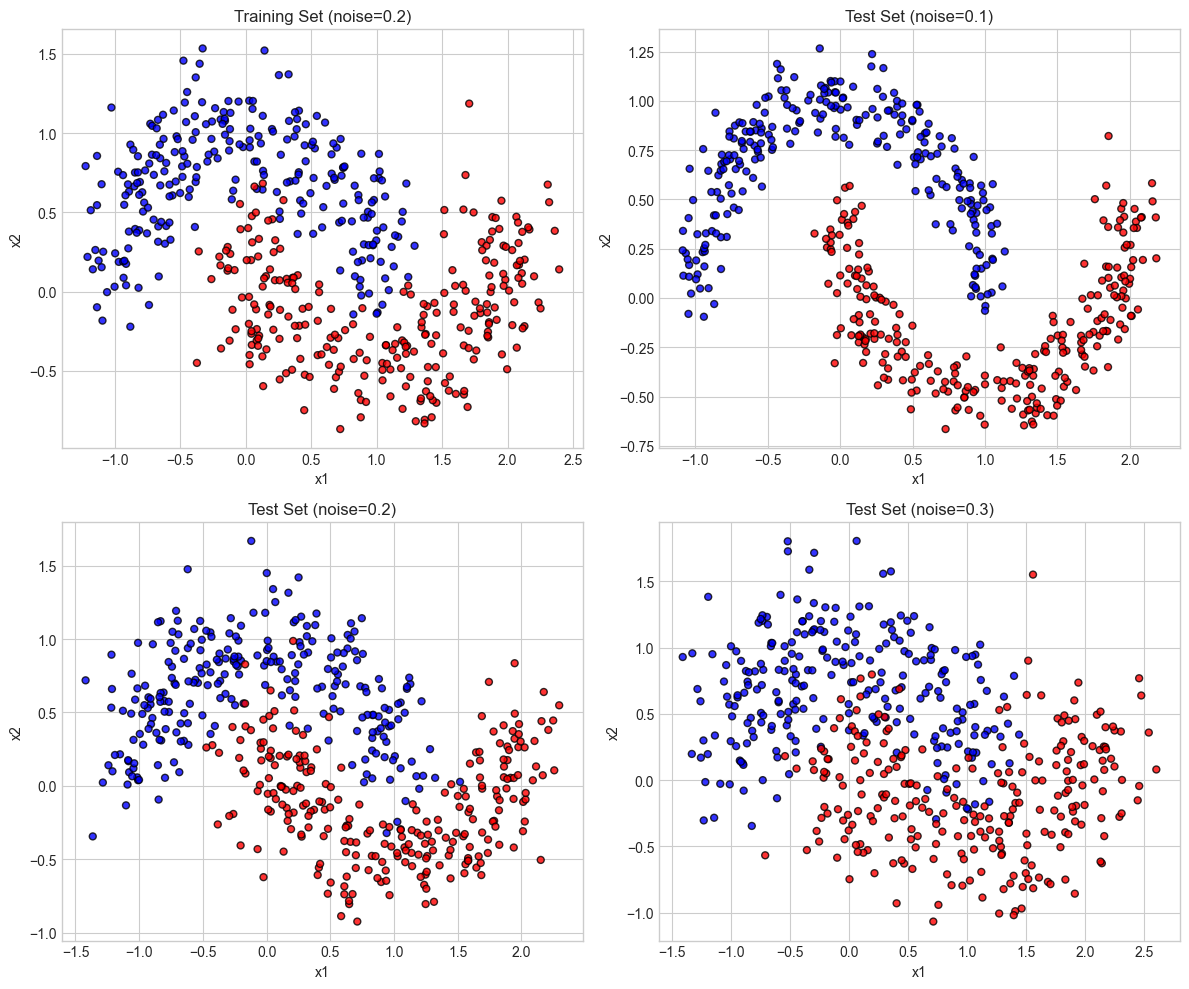

In [108]:
# Cell: Custom make_moons implementation and dataset creation (no sklearn.make_moons)
def make_moons_custom(n_samples=500, noise=0.2, random_state=None):

    if random_state is not None:
        rng = np.random.RandomState(random_state)
    else:
        rng = np.random

    n_out = n_samples // 2
    n_in = n_samples - n_out

    # Outer (first) moon
    theta_out = rng.uniform(0, math.pi, n_out)
    x_out = np.column_stack([np.cos(theta_out), np.sin(theta_out)])

    # Inner (second) moon - flipped and shifted
    theta_in = rng.uniform(0, math.pi, n_in)
    x_in = np.column_stack([1 - np.cos(theta_in),  -np.sin(theta_in) + 0.5])

    X = np.vstack([x_out, x_in])
    y = np.hstack([np.zeros(n_out, dtype=int), np.ones(n_in, dtype=int)])

    # Add isotropic Gaussian noise
    X += rng.normal(scale=noise, size=X.shape)
    return X, y

# Create datasets
N_TRAIN = 500
N_TEST = 500

X_train_raw, y_train_raw = make_moons_custom(N_TRAIN, noise=0.2, random_state=SEED)
X_test_20, y_test_20 = make_moons_custom(N_TEST, noise=0.2, random_state=SEED+1)
X_test_10, y_test_10 = make_moons_custom(N_TEST, noise=0.1, random_state=SEED)
X_test_30, y_test_30 = make_moons_custom(N_TEST, noise=0.3, random_state=SEED)

# Plot all datasets with different noise levels
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

# Training set (noise=0.2)
axes[0].scatter(X_train_raw[:,0], X_train_raw[:,1], c=y_train_raw, cmap='bwr', edgecolor='k', s=25, alpha=0.8)
axes[0].set_title('Training Set (noise=0.2)')
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')

# Test sets with different noise levels
axes[1].scatter(X_test_10[:,0], X_test_10[:,1], c=y_test_10, cmap='bwr', edgecolor='k', s=25, alpha=0.8)
axes[1].set_title('Test Set (noise=0.1)')
axes[1].set_xlabel('x1')
axes[1].set_ylabel('x2')

axes[2].scatter(X_test_20[:,0], X_test_20[:,1], c=y_test_20, cmap='bwr', edgecolor='k', s=25, alpha=0.8)
axes[2].set_title('Test Set (noise=0.2)')
axes[2].set_xlabel('x1')
axes[2].set_ylabel('x2')

axes[3].scatter(X_test_30[:,0], X_test_30[:,1], c=y_test_30, cmap='bwr', edgecolor='k', s=25, alpha=0.8)
axes[3].set_title('Test Set (noise=0.3)')
axes[3].set_xlabel('x1')
axes[3].set_ylabel('x2')

plt.tight_layout()
plt.show()

In [109]:

# Cell: Preprocessing - standardize using train statistics only, and create validation split
scaler = StandardScaler()
# Fit on training data only
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test_20_s = scaler.transform(X_test_20)
X_test_10_s = scaler.transform(X_test_10)
X_test_30_s = scaler.transform(X_test_30)

# Validation split from training set (20%)
X_train_main, X_val, y_train_main, y_val = train_test_split(
    X_train, y_train_raw, test_size=0.2, stratify=y_train_raw, random_state=SEED
)

print('Shapes:', X_train_main.shape, X_val.shape, X_test_20_s.shape)


Shapes: (400, 2) (100, 2) (500, 2)


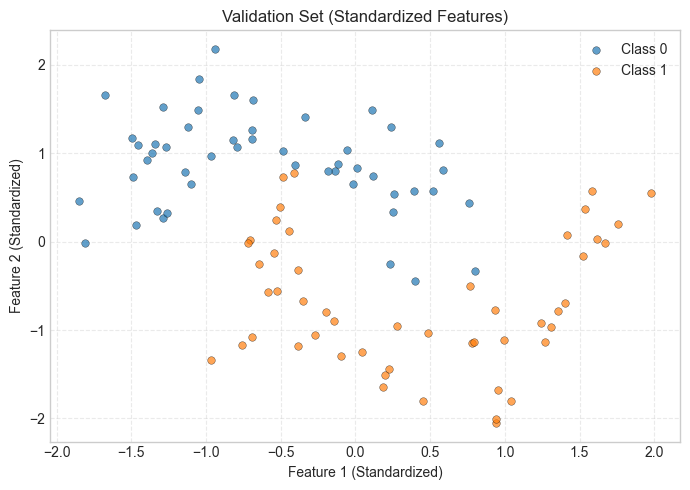

In [110]:
# Plot Validation Set Distribution
plt.figure(figsize=(7, 5))
plt.scatter(X_val[y_val == 0, 0], X_val[y_val == 0, 1], label='Class 0', alpha=0.7, s=30, edgecolor='k', linewidths=0.3)
plt.scatter(X_val[y_val == 1, 0], X_val[y_val == 1, 1], label='Class 1', alpha=0.7, s=30, edgecolor='k', linewidths=0.3)

plt.title("Validation Set (Standardized Features)")
plt.xlabel("Feature 1 (Standardized)")
plt.ylabel("Feature 2 (Standardized)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [111]:
# Cell: Define MLP (two hidden layers: 4 and 6 neurons), training loop with early stopping,
# and utilities for L1/L2 penalties and evaluation metrics.

class SimpleMLP(nn.Module):
    def __init__(self, input_dim=4, hidden1=6, hidden2=20):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2, 1)  # binary classification
    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.fc3(x)
        return x.squeeze(-1)

def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_layerwise_sparsity(model: nn.Module, tol=1e-3):
    sparsity = {}
    for name, p in model.named_parameters():
        if 'weight' in name:
            total = p.numel()
            zero = (p.abs() <= tol).sum().item()
            sparsity[name] = zero / total
    return sparsity

def train_model(model, X_train, y_train, X_val, y_val,
                epochs=1000, batch_size=64, lr=1e-3, weight_decay=0.0,
                l1_lambda=0.0, patience=50, verbose=False):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for raw logits
    dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    best = {'epoch':-1, 'val_loss':np.inf, 'state_dict':None}
    wait = 0
    history = {'train_loss':[], 'val_loss':[], 'val_auc':[]}
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)  # Outputs raw logits
            loss = criterion(logits, yb)
            # L1 penalty
            if l1_lambda > 0:
                l1_pen = 0.0
                for name, p in model.named_parameters():
                    if 'weight' in name:
                        l1_pen = l1_pen + p.abs().sum()
                loss = loss + l1_lambda * l1_pen
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        # Validation
        model.eval()
        with torch.no_grad():
            xb = torch.tensor(X_val, dtype=torch.float32).to(device)
            yb = torch.tensor(y_val, dtype=torch.float32).to(device)
            logits = model(xb)  # Outputs raw logits
            val_loss = criterion(logits, yb).item()
            val_probs = torch.sigmoid(logits).cpu().numpy()  # Convert logits to probabilities for AUC
            val_auc = roc_auc_score(y_val, val_probs)
        history['train_loss'].append(np.mean(train_losses))
        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_auc)
        if val_loss < best['val_loss'] - 1e-8:
            best.update({'epoch': epoch, 'val_loss': val_loss, 'state_dict': model.state_dict()})
            wait = 0
        else:
            wait += 1
        if verbose and (epoch % 50 == 0):
            print(f'Epoch {epoch:04d} train_loss={history["train_loss"][-1]:.4f} val_loss={val_loss:.4f} val_auc={val_auc:.4f}')
        if wait >= patience:
            if verbose:
                print(f'Early stopping at epoch {epoch}, best epoch {best["epoch"]} val_loss {best["val_loss"]:.4f}')
            break
    # load best
    if best['state_dict'] is not None:
        model.load_state_dict(best['state_dict'])
    return model, history

In [112]:

# Cell: Train baseline MLP with early stopping (no L1/L2)
model_base = SimpleMLP(input_dim=2, hidden1=4, hidden2=6)
print('Param count (baseline MLP):', count_parameters(model_base))
model_base_trained, history_base = train_model(
    model_base, X_train_main, y_train_main, X_val, y_val,
    epochs=2000, batch_size=64, lr=1e-3, patience=50, verbose=True
)

# Validation AUC
from sklearn.metrics import roc_auc_score
model_base_trained.eval()
with torch.no_grad():
    val_logits = model_base_trained(torch.tensor(X_val, dtype=torch.float32).to(device))
    val_probs = torch.sigmoid(val_logits).cpu().numpy()
val_auc_base = roc_auc_score(y_val, val_probs)
print('Base MLP validation AUC:', val_auc_base)


Param count (baseline MLP): 49
Epoch 0000 train_loss=0.7337 val_loss=0.7300 val_auc=0.0692
Epoch 0050 train_loss=0.4910 val_loss=0.4827 val_auc=0.9560
Epoch 0100 train_loss=0.2425 val_loss=0.2928 val_auc=0.9476
Epoch 0150 train_loss=0.2023 val_loss=0.2660 val_auc=0.9596
Epoch 0200 train_loss=0.2087 val_loss=0.2477 val_auc=0.9652
Epoch 0250 train_loss=0.1837 val_loss=0.2196 val_auc=0.9704
Epoch 0300 train_loss=0.1286 val_loss=0.1809 val_auc=0.9780
Epoch 0350 train_loss=0.1011 val_loss=0.1230 val_auc=0.9952
Epoch 0400 train_loss=0.0769 val_loss=0.0884 val_auc=0.9976
Epoch 0450 train_loss=0.0670 val_loss=0.0740 val_auc=0.9976
Epoch 0500 train_loss=0.0501 val_loss=0.0654 val_auc=0.9980
Epoch 0550 train_loss=0.0432 val_loss=0.0610 val_auc=0.9984
Epoch 0600 train_loss=0.0403 val_loss=0.0584 val_auc=0.9988
Epoch 0650 train_loss=0.0397 val_loss=0.0572 val_auc=0.9984
Epoch 0700 train_loss=0.0330 val_loss=0.0552 val_auc=0.9984
Epoch 0750 train_loss=0.0321 val_loss=0.0542 val_auc=0.9984
Epoch 080

In [113]:

# Cell: L1 regularization grid search
l1_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
l1_results = []
for lam in l1_grid:
    print('Training with L1 lambda =', lam)
    model = SimpleMLP(input_dim=2, hidden1=4, hidden2=6)
    m_trained, hist = train_model(model, X_train_main, y_train_main, X_val, y_val,
                                  epochs=2000, batch_size=64, lr=1e-3, l1_lambda=lam, patience=50, verbose=False)
    # Compute validation AUC
    m_trained.eval()
    with torch.no_grad():
        val_logits = m_trained(torch.tensor(X_val, dtype=torch.float32).to(device))
        val_probs = torch.sigmoid(val_logits).cpu().numpy()
    val_auc = roc_auc_score(y_val, val_probs)
    sparsity = get_layerwise_sparsity(m_trained, tol=1e-3)
    l1_results.append({'lambda':lam, 'val_auc':val_auc, 'sparsity':sparsity, 'params':count_parameters(m_trained)})
    print(f' lambda={lam:.0e} val_auc={val_auc:.4f} sparsity={sparsity}')
# Convert to DataFrame for easy plotting
l1_df = pd.DataFrame([{'lambda':r['lambda'], 'val_auc':r['val_auc'], 'params':r['params']} for r in l1_results])


Training with L1 lambda = 1e-06
 lambda=1e-06 val_auc=0.9576 sparsity={'fc1.weight': 0.0, 'fc2.weight': 0.5416666666666666, 'fc3.weight': 0.5}
Training with L1 lambda = 3e-06
 lambda=3e-06 val_auc=0.9656 sparsity={'fc1.weight': 0.0, 'fc2.weight': 0.0, 'fc3.weight': 0.0}
Training with L1 lambda = 1e-05
 lambda=1e-05 val_auc=0.9572 sparsity={'fc1.weight': 0.0, 'fc2.weight': 0.0, 'fc3.weight': 0.0}
Training with L1 lambda = 3e-05
 lambda=3e-05 val_auc=0.9984 sparsity={'fc1.weight': 0.0, 'fc2.weight': 0.16666666666666666, 'fc3.weight': 0.16666666666666666}
Training with L1 lambda = 0.0001
 lambda=1e-04 val_auc=0.9660 sparsity={'fc1.weight': 0.0, 'fc2.weight': 0.16666666666666666, 'fc3.weight': 0.16666666666666666}
Training with L1 lambda = 0.0003
 lambda=3e-04 val_auc=0.9988 sparsity={'fc1.weight': 0.0, 'fc2.weight': 0.3333333333333333, 'fc3.weight': 0.3333333333333333}


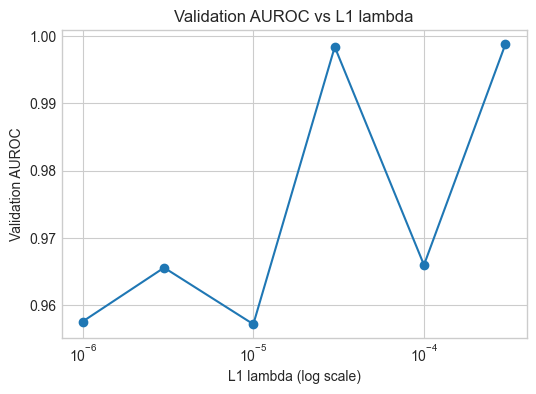

In [114]:

# Cell: Plot validation AUC vs L1 lambda and show sparsity
plt.figure(figsize=(6,4))
plt.semilogx(l1_df['lambda'], l1_df['val_auc'], marker='o')
plt.xlabel('L1 lambda (log scale)'); plt.ylabel('Validation AUROC')
plt.title('Validation AUROC vs L1 lambda')
plt.grid(True)
plt.show()

## plot layerwise sparcity vs L1 lambda

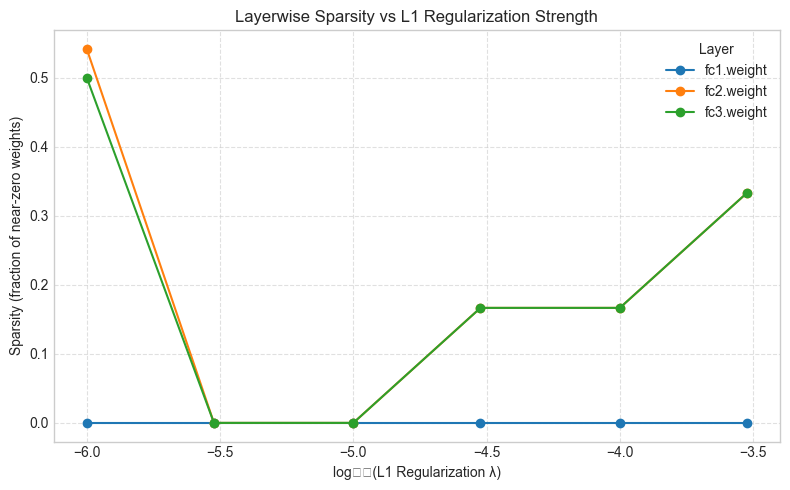

In [115]:
# Extract layerwise sparsity across lambdas
layers = ['fc1.weight', 'fc2.weight', 'fc3.weight']
lambda_vals = [r['lambda'] for r in l1_results]

# Build a DataFrame for easier plotting
records = []
for r in l1_results:
    for layer in layers:
        records.append({'lambda': r['lambda'], 'layer': layer, 'sparsity': r['sparsity'][layer]})
sparsity_df = pd.DataFrame(records)

# Plot sparsity vs L1 lambda (log scale)
plt.figure(figsize=(8, 5))
for layer, df_layer in sparsity_df.groupby('layer'):
    plt.plot(np.log10(df_layer['lambda']), df_layer['sparsity'], marker='o', label=layer)

plt.xlabel('log₁₀(L1 Regularization λ)')
plt.ylabel('Sparsity (fraction of near-zero weights)')
plt.title('Layerwise Sparsity vs L1 Regularization Strength')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Layer')
plt.tight_layout()
plt.show()


In [116]:

# Cell: L2 (weight decay) tuning via validation
l2_grid = [0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
l2_results = []
for wd in l2_grid:
    print('Training with weight_decay =', wd)
    model = SimpleMLP(input_dim=2, hidden1=4, hidden2=6)
    m_trained, hist = train_model(model, X_train_main, y_train_main, X_val, y_val,
                                  epochs=2000, batch_size=64, lr=1e-3, weight_decay=wd, patience=50, verbose=False)
    # Compute validation AUC
    m_trained.eval()
    with torch.no_grad():
        val_logits = m_trained(torch.tensor(X_val, dtype=torch.float32).to(device))
        val_probs = torch.sigmoid(val_logits).cpu().numpy()
    val_auc = roc_auc_score(y_val, val_probs)
    l2_results.append({'weight_decay':wd, 'val_auc':val_auc, 'params':count_parameters(m_trained)})
    print(f' wd={wd} val_auc={val_auc:.4f}')
l2_df = pd.DataFrame(l2_results)
l2_df


Training with weight_decay = 0.0
 wd=0.0 val_auc=0.9584
Training with weight_decay = 1e-06
 wd=1e-06 val_auc=0.9988
Training with weight_decay = 1e-05
 wd=1e-05 val_auc=0.9992
Training with weight_decay = 0.0001
 wd=0.0001 val_auc=0.9580
Training with weight_decay = 0.001
 wd=0.001 val_auc=0.9984
Training with weight_decay = 0.01
 wd=0.01 val_auc=0.9680


,weight_decay,val_auc,params
0,0.000000,0.9584,49
1,0.000001,0.9988,49
2,0.000010,0.9992,49
3,0.000100,0.9580,49
4,0.001000,0.9984,49
5,0.010000,0.9680,49


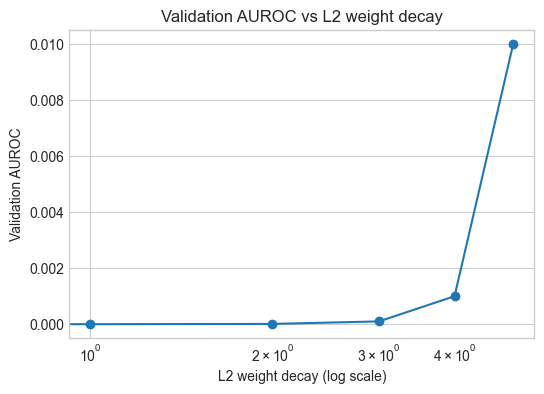

,weight_decay
0,0.000000
1,0.000001
2,0.000010
3,0.000100
4,0.001000
5,0.010000


In [117]:
# Cell: Plot validation AUC vs L2 lambda and show sparsity
plt.figure(figsize=(6,4))
plt.semilogx(l2_df['weight_decay'] + 1e-10, marker='o')
plt.xlabel('L2 weight decay (log scale)'); plt.ylabel('Validation AUROC')
plt.title('Validation AUROC vs L2 weight decay')
plt.grid(True)
plt.show()
# Sparsity table for L2 (though L2 does not induce sparsity)
l2_df
spars_rows = []
for r in l2_results:
    spars_rows.append({'weight_decay': r['weight_decay']})
spars_df = pd.DataFrame(spars_rows)
spars_df

In [118]:
# Cell: Logistic Regression with polynomial features (degree 2 and 3) - Manual implementation
poly_results = []

def create_polynomial_features(X, degree):
    """Manually creates polynomial features up to the specified degree."""
    X_poly = X
    for d in range(2, degree + 1):
        X_poly = np.hstack((X_poly, (X[:, 0]**d).reshape(-1, 1), (X[:, 1]**d).reshape(-1, 1)))
        # Add interaction term for degree 2 and higher
        if d >= 2:
             X_poly = np.hstack((X_poly, (X[:, 0] * X[:, 1]).reshape(-1, 1)))
    return X_poly

for deg in [2, 3]:
    # Manually create polynomial features
    X_train_poly = create_polynomial_features(X_train_main, deg)
    X_val_poly = create_polynomial_features(X_val, deg)

    clf = LogisticRegression(max_iter=5000, random_state=SEED)
    clf.fit(X_train_poly, y_train_main)
    val_probs = clf.predict_proba(X_val_poly)[:,1]
    val_auc = roc_auc_score(y_val, val_probs)
    poly_results.append({'degree':deg, 'val_auc':val_auc, 'coef_count': clf.coef_.size + clf.intercept_.size})
    print(f'Degree {deg} val_auc={val_auc:.4f} coef_count={clf.coef_.size}')
poly_df = pd.DataFrame(poly_results)
poly_df

Degree 2 val_auc=0.9560 coef_count=5
Degree 3 val_auc=0.9964 coef_count=8


,degree,val_auc,coef_count
0,2,0.9560,6
1,3,0.9964,9


In [119]:
# Cell: Evaluate the trained best models on test sets (noise 0.1, 0.2, 0.3)
# For L1 and L2 pick best trained model from earlier results (best val_auc)

# Find best L1 model (highest val_auc)
best_l1 = max(l1_results, key=lambda r: r['val_auc'])
# Re-train best L1 model to ensure we have model object (with same lambda) -- small redundancy
best_l1_lambda = best_l1['lambda']
model_l1 = SimpleMLP(input_dim=2, hidden1=4, hidden2=6)
model_l1_trained, _ = train_model(model_l1, X_train_main, y_train_main, X_val, y_val,
                                  epochs=800, batch_size=64, lr=1e-3, l1_lambda=best_l1_lambda, patience=50, verbose=False)

# Best L2 by val_auc
best_l2_entry = max(l2_results, key=lambda r: r['val_auc'])
best_l2_wd = best_l2_entry['weight_decay']
model_l2 = SimpleMLP(input_dim=2, hidden1=4, hidden2=6)
model_l2_trained, _ = train_model(model_l2, X_train_main, y_train_main, X_val, y_val,
                                  epochs=800, batch_size=64, lr=1e-3, weight_decay=best_l2_wd, patience=50, verbose=False)

# Base MLP already trained as model_base_trained
# Logistic regression: choose degree 2 model (you can evaluate both)
# Manually create polynomial features for degree 2
X_train_poly2 = create_polynomial_features(X_train_main, 2)
X_test_poly2_10 = create_polynomial_features(X_test_10_s, 2)
X_test_poly2_20 = create_polynomial_features(X_test_20_s, 2)
X_test_poly2_30 = create_polynomial_features(X_test_30_s, 2)

clf_poly2 = LogisticRegression(max_iter=5000, random_state=SEED)
clf_poly2.fit(X_train_poly2, y_train_main)

# Manually create polynomial features for degree 3
X_train_poly3 = create_polynomial_features(X_train_main, 3)
X_test_poly3_10 = create_polynomial_features(X_test_10_s, 3)
X_test_poly3_20 = create_polynomial_features(X_test_20_s, 3)
X_test_poly3_30 = create_polynomial_features(X_test_30_s, 3)

clf_poly3 = LogisticRegression(max_iter=5000, random_state=SEED)
clf_poly3.fit(X_train_poly3, y_train_main)


# Helper to evaluate
def eval_model_torch(model, X):
    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(X, dtype=torch.float32).to(device))
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= 0.5).astype(int)
    return preds, probs

def eval_lr(clf, X_poly):
    probs = clf.predict_proba(X_poly)[:,1]
    preds = (probs >= 0.5).astype(int)
    return preds, probs

# Evaluate on the three test sets
models_info = []
# Base MLP
for (Xtest, ytest, noise_label) in [(X_test_10_s, y_test_10, 0.1), (X_test_20_s, y_test_20, 0.2), (X_test_30_s, y_test_30, 0.3)]:
    p, prob = eval_model_torch(model_base_trained, Xtest)
    TP = ((p == 1) & (ytest == 1)).sum()
    TN = ((p == 0) & (ytest == 0)).sum()
    FP = ((p == 1) & (ytest == 0)).sum()
    FN = ((p == 0) & (ytest == 1)).sum()
    print(f"Noise: {noise_label}, TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")
    acc = (TP + TN) / (TP + TN + FP + FN)
    print(f"Calculated Accuracy: {acc}")
    aucs = roc_auc_score(ytest, prob)
    models_info.append({'model':'MLP_base', 'noise':noise_label, 'acc':acc, 'auc':aucs, 'params':count_parameters(model_base_trained)})
# L1 MLP
for (Xtest, ytest, noise_label) in [(X_test_10_s, y_test_10, 0.1), (X_test_20_s, y_test_20, 0.2), (X_test_30_s, y_test_30, 0.3)]:
    p, prob = eval_model_torch(model_l1_trained, Xtest)
    TP = ((p == 1) & (ytest == 1)).sum()
    TN = ((p == 0) & (ytest == 0)).sum()
    FP = ((p == 1) & (ytest == 0)).sum()
    FN = ((p == 0) & (ytest == 1)).sum()
    acc = (TP + TN) / (TP + TN + FP + FN)
    aucs = roc_auc_score(ytest, prob)
    models_info.append({'model':'MLP_L1', 'noise':noise_label, 'acc':acc, 'auc':aucs, 'params':count_parameters(model_l1_trained)})
# L2 MLP
for (Xtest, ytest, noise_label) in [(X_test_10_s, y_test_10, 0.1), (X_test_20_s, y_test_20, 0.2), (X_test_30_s, y_test_30, 0.3)]:
    p, prob = eval_model_torch(model_l2_trained, Xtest)
    TP = ((p == 1) & (ytest == 1)).sum()
    TN = ((p == 0) & (ytest == 0)).sum()
    FP = ((p == 1) & (ytest == 0)).sum()
    FN = ((p == 0) & (ytest == 1)).sum()
    acc = (TP + TN) / (TP + TN + FP + FN)
    aucs = roc_auc_score(ytest, prob)
    models_info.append({'model':'MLP_L2', 'noise':noise_label, 'acc':acc, 'auc':aucs, 'params':count_parameters(model_l2_trained)})
# Logistic degree2
for (Xtest_poly, ytest, noise_label) in [(X_test_poly2_10, y_test_10, 0.1), (X_test_poly2_20, y_test_20, 0.2), (X_test_poly2_30, y_test_30, 0.3)]:
    p, prob = eval_lr(clf_poly2, Xtest_poly)
    TP = ((p == 1) & (ytest == 1)).sum()
    TN = ((p == 0) & (ytest == 0)).sum()
    FP = ((p == 1) & (ytest == 0)).sum()
    FN = ((p == 0) & (ytest == 1)).sum()
    acc = (TP + TN) / (TP + TN + FP + FN)
    aucs = roc_auc_score(ytest, prob)
    models_info.append({'model':'LogReg_deg2', 'noise':noise_label, 'acc':acc, 'auc':aucs, 'params':clf_poly2.coef_.size + clf_poly2.intercept_.size})
# Logistic degree3
for (Xtest_poly, ytest, noise_label) in [(X_test_poly3_10, y_test_10, 0.1), (X_test_poly3_20, y_test_20, 0.2), (X_test_poly3_30, y_test_30, 0.3)]:
    p, prob = eval_lr(clf_poly3, Xtest_poly)
    TP = ((p == 1) & (ytest == 1)).sum()
    TN = ((p == 0) & (ytest == 0)).sum()
    FP = ((p == 1) & (ytest == 0)).sum()
    FN = ((p == 0) & (ytest == 1)).sum()
    acc = (TP + TN) / (TP + TN + FP + FN)
    aucs = roc_auc_score(ytest, prob)
    models_info.append({'model':'LogReg_deg3', 'noise':noise_label, 'acc':acc, 'auc':aucs, 'params':clf_poly3.coef_.size + clf_poly3.intercept_.size})

results_df = pd.DataFrame(models_info)
results_pivot_acc = results_df.pivot(index='model', columns='noise', values='acc')
results_pivot_auc = results_df.pivot(index='model', columns='noise', values='auc')

Noise: 0.1, TP: 250, TN: 250, FP: 0, FN: 0
Calculated Accuracy: 1.0
Noise: 0.2, TP: 242, TN: 245, FP: 5, FN: 8
Calculated Accuracy: 0.974
Noise: 0.3, TP: 229, TN: 228, FP: 22, FN: 21
Calculated Accuracy: 0.914


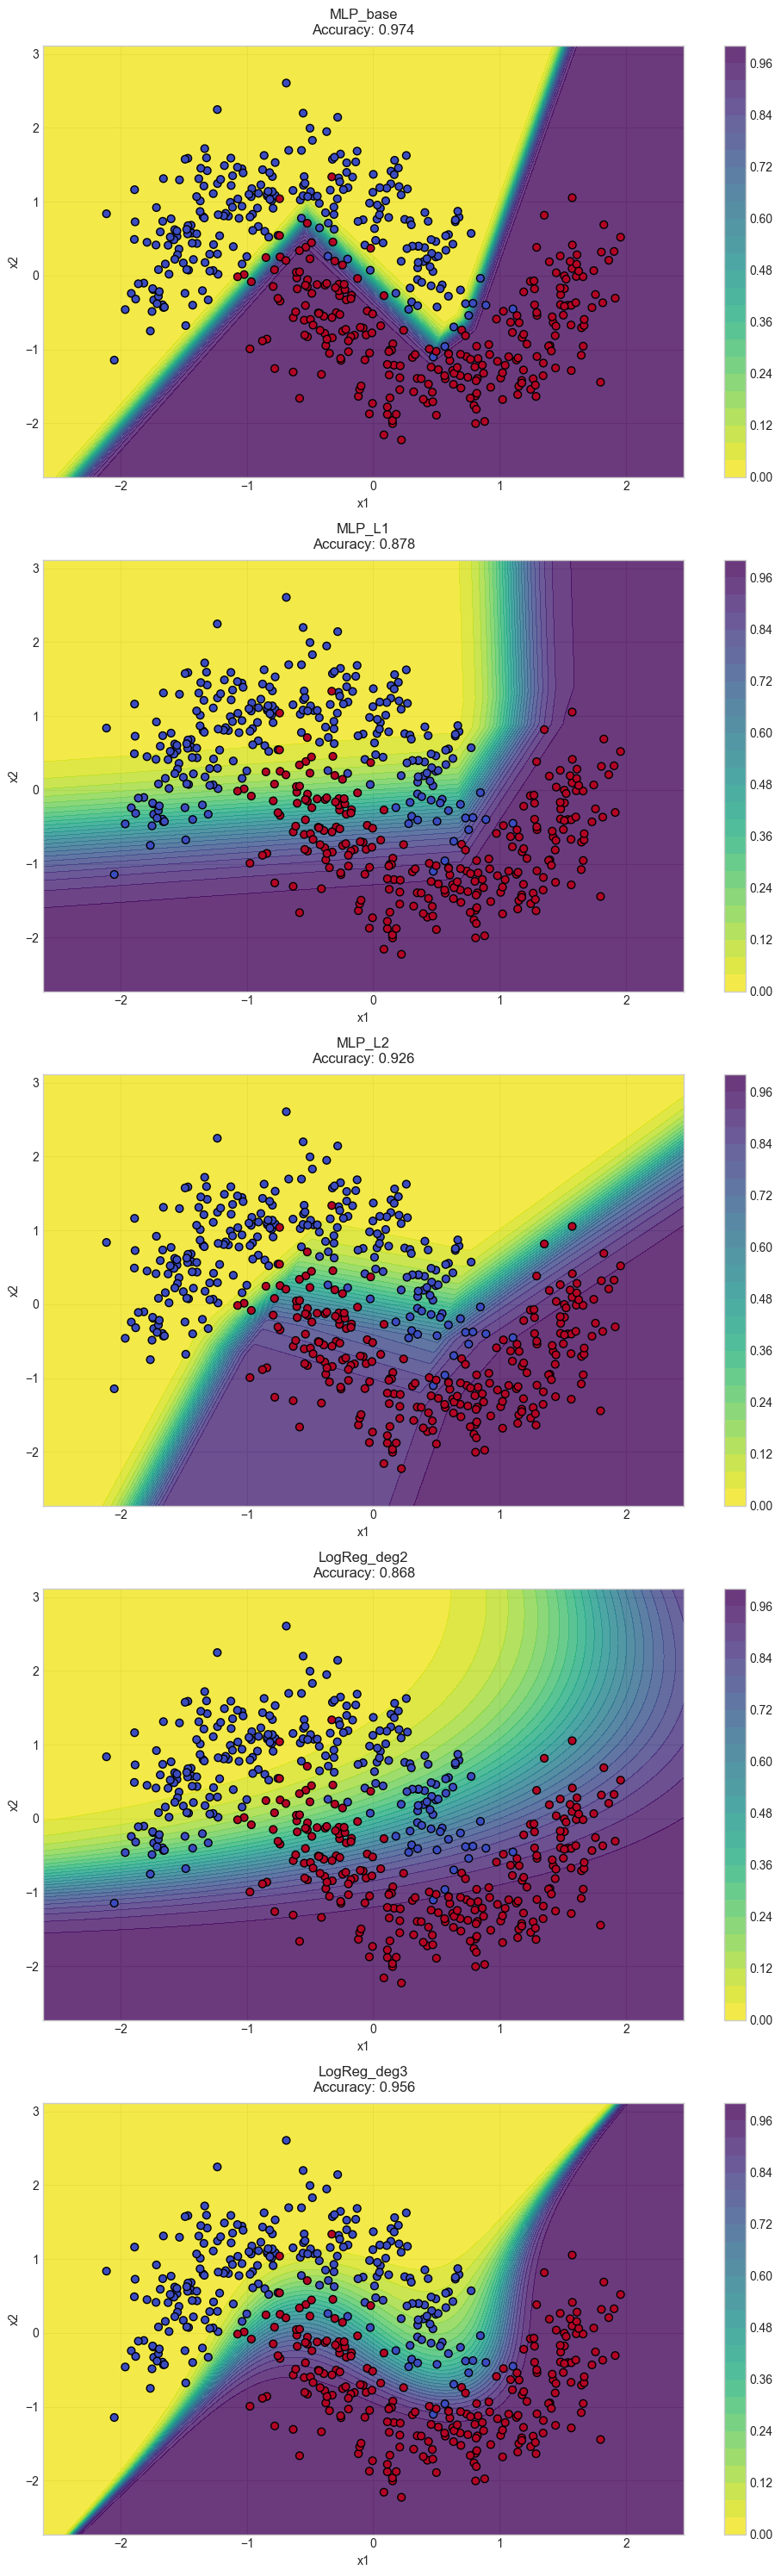

In [120]:
# Cell: Decision boundaries for the four main models (noise 0.2). We'll plot MLP_base, MLP_L1, MLP_L2, LogReg_deg2
xx_min, xx_max = X_test_20_s[:, 0].min() - 0.5, X_test_20_s[:, 0].max() + 0.5
yy_min, yy_max = X_test_20_s[:, 1].min() - 0.5, X_test_20_s[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(xx_min, xx_max, 300),
                     np.linspace(yy_min, yy_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

# Create polynomial features for the grid for Logistic Regression models
grid_poly2 = create_polynomial_features(grid, 2)
grid_poly3 = create_polynomial_features(grid, 3)

# Get accuracies for noise = 0.2
acc_base = results_df[(results_df['model'] == 'MLP_base') & (results_df['noise'] == 0.2)]['acc'].iloc[0]
acc_l1 = results_df[(results_df['model'] == 'MLP_L1') & (results_df['noise'] == 0.2)]['acc'].iloc[0]
acc_l2 = results_df[(results_df['model'] == 'MLP_L2') & (results_df['noise'] == 0.2)]['acc'].iloc[0]
acc_logreg2 = results_df[(results_df['model'] == 'LogReg_deg2') & (results_df['noise'] == 0.2)]['acc'].iloc[0]
acc_logreg3 = results_df[(results_df['model'] == 'LogReg_deg3') & (results_df['noise'] == 0.2)]['acc'].iloc[0]

# Create figure with 5 rows and 1 column
fig, axes = plt.subplots(5, 1, figsize=(10, 30))
models_for_plot = [
    ('MLP_base', model_base_trained, None, acc_base),
    ('MLP_L1', model_l1_trained, None, acc_l1),
    ('MLP_L2', model_l2_trained, None, acc_l2),
    ('LogReg_deg2', clf_poly2, grid_poly2, acc_logreg2),
    ('LogReg_deg3', clf_poly3, grid_poly3, acc_logreg3)
]

for ax, (name, mdl, poly_grid, acc) in zip(axes, models_for_plot):
    if 'LogReg' in name:
        probs = mdl.predict_proba(poly_grid)[:, 1].reshape(xx.shape)
    else:
        mdl.eval()
        with torch.no_grad():
            logits = mdl(torch.tensor(grid, dtype=torch.float32).to(device))
            probs = torch.sigmoid(logits).cpu().numpy().reshape(xx.shape)

    # Create contour plot with new color scheme
    contour = ax.contourf(xx, yy, probs, levels=25, cmap='viridis_r', alpha=0.8)

    # Add scatter plot of test points
    ax.scatter(X_test_20_s[:, 0], X_test_20_s[:, 1], c=y_test_20,
               cmap='coolwarm', edgecolor='k', s=40)

    # Add title with accuracy
    ax.set_title(f'{name}\nAccuracy: {acc:.3f}', fontsize=12, pad=10)

    # Add axes labels
    ax.set_xlabel('x1', fontsize=10)
    ax.set_ylabel('x2', fontsize=10)

    # Add colorbar
    plt.colorbar(contour, ax=ax)

plt.tight_layout()
plt.show()


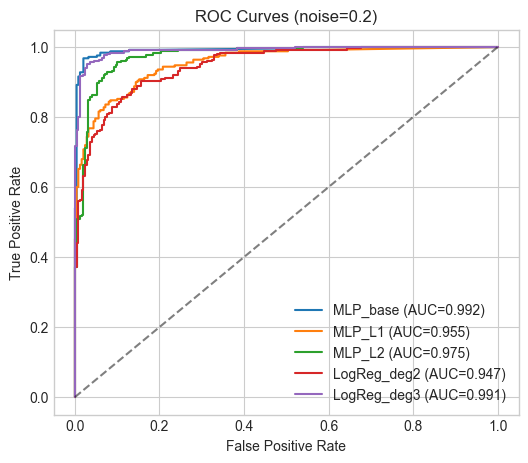

In [121]:
# Cell: ROC curves (noise 0.2) for main models
plt.figure(figsize=(6,5))
from sklearn.metrics import roc_curve
def plot_roc_for_model(name, predict_func):
    probs = predict_func(X_test_20_s)
    fpr, tpr, _ = roc_curve(y_test_20, probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc(fpr,tpr):.3f})')
  
# Helper to evaluate Logistic Regression with polynomial features for ROC curve
def eval_lr_poly(clf, X, degree):
    X_poly = create_polynomial_features(X, degree)
    probs = clf.predict_proba(X_poly)[:, 1]
    return probs

plot_roc_for_model('MLP_base', lambda X: eval_model_torch(model_base_trained, X)[1])
plot_roc_for_model('MLP_L1', lambda X: eval_model_torch(model_l1_trained, X)[1])
plot_roc_for_model('MLP_L2', lambda X: eval_model_torch(model_l2_trained, X)[1])
plot_roc_for_model('LogReg_deg2', lambda X: eval_lr_poly(clf_poly2, X, 2))
plot_roc_for_model('LogReg_deg3', lambda X: eval_lr_poly(clf_poly3, X, 3))

plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves (noise=0.2)')
plt.legend(); plt.grid(True)
plt.show()

In [122]:
# Cell: Class imbalance in training set (70:30). We'll create a new imbalanced training set sized N_TRAIN with same distribution.
def make_imbalanced_train(X_raw, y_raw, target_ratio=0.7, random_state=SEED):
    # target_ratio = fraction of class 0
    rng = np.random.RandomState(random_state)
    # separate classes
    X0 = X_raw[y_raw == 0]
    X1 = X_raw[y_raw == 1]
    n = len(y_raw)
    n0 = int(n * target_ratio)
    n1 = n - n0
    # sample with replacement if not enough samples (we have enough though)
    idx0 = rng.choice(len(X0), size=n0, replace=True)
    idx1 = rng.choice(len(X1), size=n1, replace=True)
    X_new = np.vstack([X0[idx0], X1[idx1]])
    y_new = np.hstack([np.zeros(n0, dtype=int), np.ones(n1, dtype=int)])
    # shuffle
    perm = rng.permutation(n)
    return X_new[perm], y_new[perm]

# --- Create imbalanced dataset ---
X_train_imb_raw, y_train_imb_raw = make_imbalanced_train(X_train_raw, y_train_raw, target_ratio=0.7, random_state=SEED)
# Standardize using original train scaler (fit on original balanced train)
X_train_imb = scaler.transform(X_train_imb_raw)
# Validation split from imbalanced train
X_train_imb_main, X_val_imb, y_train_imb_main, y_val_imb = train_test_split(
    X_train_imb, y_train_imb_raw, test_size=0.2, stratify=y_train_imb_raw, random_state=SEED
)

print('Imbalanced train class distribution (train main):', np.bincount(y_train_imb_main), 'val:', np.bincount(y_val_imb))

# --- Containers for results ---
imbalanced_results = []


print("\nTraining MLP (Base) on imbalanced data ....")
model_imb_base = SimpleMLP(input_dim=2, hidden1=4, hidden2=6)
model_imb_base_trained, _ = train_model(model_imb_base, X_train_imb_main, y_train_imb_main, X_val_imb, y_val_imb,
                                        epochs=2000, patience=50, verbose=False)

# Validation evaluation
p_val_base, prob_val_base = eval_model_torch(model_imb_base_trained, X_val_imb)
acc_val_base = accuracy_score(y_val_imb, p_val_base)
auc_val_base = roc_auc_score(y_val_imb, prob_val_base)

# Test evaluation
p_imb_base, prob_imb_base = eval_model_torch(model_imb_base_trained, X_test_20_s)
acc_imb_base = accuracy_score(y_test_20, p_imb_base)
auc_imb_base = roc_auc_score(y_test_20, prob_imb_base)

imbalanced_results.append({'model': 'MLP (Base)', 
                           'val_acc': acc_val_base, 'val_auc': auc_val_base,
                           'test_acc': acc_imb_base, 'test_auc': auc_imb_base})

print(f'MLP (Base) — Val: ACC={acc_val_base:.3f}, AUC={auc_val_base:.3f} | Test: ACC={acc_imb_base:.3f}, AUC={auc_imb_base:.3f}')


print("\nTraining MLP (L1) on imbalanced data ....")
best_l1_lambda = max(l1_results, key=lambda r: r['val_auc'])['lambda']
model_imb_l1 = SimpleMLP(input_dim=2, hidden1=4, hidden2=6)
model_imb_l1_trained, _ = train_model(model_imb_l1, X_train_imb_main, y_train_imb_main, X_val_imb, y_val_imb,
                                      epochs=2000, batch_size=64, lr=1e-3, l1_lambda=best_l1_lambda, patience=50, verbose=False)

# Validation evaluation
p_val_l1, prob_val_l1 = eval_model_torch(model_imb_l1_trained, X_val_imb)
acc_val_l1 = accuracy_score(y_val_imb, p_val_l1)
auc_val_l1 = roc_auc_score(y_val_imb, prob_val_l1)

# Test evaluation
p_imb_l1, prob_imb_l1 = eval_model_torch(model_imb_l1_trained, X_test_20_s)
acc_imb_l1 = accuracy_score(y_test_20, p_imb_l1)
auc_imb_l1 = roc_auc_score(y_test_20, prob_imb_l1)

imbalanced_results.append({'model': 'MLP (L1)', 
                           'val_acc': acc_val_l1, 'val_auc': auc_val_l1,
                           'test_acc': acc_imb_l1, 'test_auc': auc_imb_l1})

print(f'MLP (L1) — Val: ACC={acc_val_l1:.3f}, AUC={auc_val_l1:.3f} | Test: ACC={acc_imb_l1:.3f}, AUC={auc_imb_l1:.3f}')


print("\nTraining MLP (L2) on imbalanced data ....")
best_l2_wd = max(l2_results, key=lambda r: r['val_auc'])['weight_decay']
model_imb_l2 = SimpleMLP(input_dim=2, hidden1=4, hidden2=6)
model_imb_l2_trained, _ = train_model(model_imb_l2, X_train_imb_main, y_train_imb_main, X_val_imb, y_val_imb,
                                      epochs=2000, batch_size=64, lr=1e-3, weight_decay=best_l2_wd, patience=50, verbose=False)

# Validation evaluation
p_val_l2, prob_val_l2 = eval_model_torch(model_imb_l2_trained, X_val_imb)
acc_val_l2 = accuracy_score(y_val_imb, p_val_l2)
auc_val_l2 = roc_auc_score(y_val_imb, prob_val_l2)

# Test evaluation
p_imb_l2, prob_imb_l2 = eval_model_torch(model_imb_l2_trained, X_test_20_s)
acc_imb_l2 = accuracy_score(y_test_20, p_imb_l2)
auc_imb_l2 = roc_auc_score(y_test_20, prob_imb_l2)

imbalanced_results.append({'model': 'MLP (L2)', 
                           'val_acc': acc_val_l2, 'val_auc': auc_val_l2,
                           'test_acc': acc_imb_l2, 'test_auc': auc_imb_l2})

print(f'MLP (L2) — Val: ACC={acc_val_l2:.3f}, AUC={auc_val_l2:.3f} | Test: ACC={acc_imb_l2:.3f}, AUC={auc_imb_l2:.3f}')


print("\nTraining LogReg (deg=2) on imbalanced data ....")
X_train_imb_poly2 = create_polynomial_features(X_train_imb_main, 2)
X_val_imb_poly2 = create_polynomial_features(X_val_imb, 2)
X_test_20_s_poly2 = create_polynomial_features(X_test_20_s, 2)

clf_imb_poly2 = LogisticRegression(max_iter=5000, random_state=SEED)
clf_imb_poly2.fit(X_train_imb_poly2, y_train_imb_main)

# Validation
p_val_poly2, prob_val_poly2 = eval_lr(clf_imb_poly2, X_val_imb_poly2)
acc_val_poly2 = accuracy_score(y_val_imb, p_val_poly2)
auc_val_poly2 = roc_auc_score(y_val_imb, prob_val_poly2)

# Test
p_imb_poly2, prob_imb_poly2 = eval_lr(clf_imb_poly2, X_test_20_s_poly2)
acc_imb_poly2 = accuracy_score(y_test_20, p_imb_poly2)
auc_imb_poly2 = roc_auc_score(y_test_20, prob_imb_poly2)

imbalanced_results.append({'model': 'LogReg (deg=2)', 
                           'val_acc': acc_val_poly2, 'val_auc': auc_val_poly2,
                           'test_acc': acc_imb_poly2, 'test_auc': auc_imb_poly2})

print(f'LogReg (deg=2) — Val: ACC={acc_val_poly2:.3f}, AUC={auc_val_poly2:.3f} | Test: ACC={acc_imb_poly2:.3f}, AUC={auc_imb_poly2:.3f}')



print("\nTraining LogReg (deg=3) on imbalanced data ....")
X_train_imb_poly3 = create_polynomial_features(X_train_imb_main, 3)
X_val_imb_poly3 = create_polynomial_features(X_val_imb, 3)
X_test_20_s_poly3 = create_polynomial_features(X_test_20_s, 3)

clf_imb_poly3 = LogisticRegression(max_iter=5000, random_state=SEED)
clf_imb_poly3.fit(X_train_imb_poly3, y_train_imb_main)

# Validation
p_val_poly3, prob_val_poly3 = eval_lr(clf_imb_poly3, X_val_imb_poly3)
acc_val_poly3 = accuracy_score(y_val_imb, p_val_poly3)
auc_val_poly3 = roc_auc_score(y_val_imb, prob_val_poly3)

# Test
p_imb_poly3, prob_imb_poly3 = eval_lr(clf_imb_poly3, X_test_20_s_poly3)
acc_imb_poly3 = accuracy_score(y_test_20, p_imb_poly3)
auc_imb_poly3 = roc_auc_score(y_test_20, prob_imb_poly3)

imbalanced_results.append({'model': 'LogReg (deg=3)', 
                           'val_acc': acc_val_poly3, 'val_auc': auc_val_poly3,
                           'test_acc': acc_imb_poly3, 'test_auc': auc_imb_poly3})

print(f'LogReg (deg=3) — Val: ACC={acc_val_poly3:.3f}, AUC={auc_val_poly3:.3f} | Test: ACC={acc_imb_poly3:.3f}, AUC={auc_imb_poly3:.3f}')


imbalanced_results_df = pd.DataFrame(imbalanced_results)
print("\nValidation and Test Results on Imbalanced Models:")
display(imbalanced_results_df)


Imbalanced train class distribution (train main): [280 120] val: [70 30]

Training MLP (Base) on imbalanced data ....
MLP (Base) — Val: ACC=0.970, AUC=0.997 | Test: ACC=0.958, AUC=0.994

Training MLP (L1) on imbalanced data ....
MLP (L1) — Val: ACC=0.970, AUC=0.998 | Test: ACC=0.968, AUC=0.994

Training MLP (L2) on imbalanced data ....
MLP (L2) — Val: ACC=0.930, AUC=0.972 | Test: ACC=0.852, AUC=0.948

Training LogReg (deg=2) on imbalanced data ....
LogReg (deg=2) — Val: ACC=0.930, AUC=0.973 | Test: ACC=0.850, AUC=0.948

Training LogReg (deg=3) on imbalanced data ....
LogReg (deg=3) — Val: ACC=0.970, AUC=0.999 | Test: ACC=0.962, AUC=0.991

Validation and Test Results on Imbalanced Models:


,model,val_acc,val_auc,test_acc,test_auc
0,MLP (Base),0.97,0.997143,0.958,0.993552
1,MLP (L1),0.97,0.998095,0.968,0.994320
2,MLP (L2),0.93,0.972381,0.852,0.947696
3,LogReg (deg=2),0.93,0.973333,0.850,0.948048
4,LogReg (deg=3),0.97,0.998571,0.962,0.990720


In [ ]:
# --- Compute best L1 and L2 parameters ---
best_l1_lambda = best_l1['lambda']
best_l2_wd = best_l2_entry['weight_decay']

# --- Create summary table ---
summary_data = []

# Helper function to format numeric results safely
def fmt(x): 
    return '{:.3f}'.format(x) if pd.notna(x) else '-'

model_base_trained.eval()
with torch.no_grad():
    val_logits = model_base_trained(torch.tensor(X_val, dtype=torch.float32).to(device))
    val_probs = torch.sigmoid(val_logits).cpu().numpy()
val_preds = (val_probs > 0.5).astype(int)
val_acc_base = accuracy_score(y_val, val_preds)
val_auc_base = roc_auc_score(y_val, val_probs)

base_info = {
    'Model': 'MLP (Base)',
    'Parameters': count_parameters(model_base_trained),
    'Architecture': '2-4-6-1',
    'Regularization': 'Early stopping only',
    'Val Acc': val_acc_base,
    'Val AUC': val_auc_base,
    'Test Acc (0.1)': results_df.query("model=='MLP_base' and noise==0.1")['acc'].iloc[0],
    'Test Acc (0.2)': results_df.query("model=='MLP_base' and noise==0.2")['acc'].iloc[0],
    'Test Acc (0.3)': results_df.query("model=='MLP_base' and noise==0.3")['acc'].iloc[0],
    'Test AUC (0.2)': results_df.query("model=='MLP_base' and noise==0.2")['auc'].iloc[0],
}
summary_data.append(base_info)


model_l1_trained.eval()
with torch.no_grad():
    val_logits = model_l1_trained(torch.tensor(X_val, dtype=torch.float32).to(device))
    val_probs = torch.sigmoid(val_logits).cpu().numpy()
val_preds = (val_probs > 0.5).astype(int)
val_acc_l1 = accuracy_score(y_val, val_preds)
val_auc_l1 = roc_auc_score(y_val, val_probs)

l1_info = {
    'Model': 'MLP (L1)',
    'Parameters': count_parameters(model_l1_trained),
    'Architecture': '2-4-6-1',
    'Regularization': f'L1 (λ={best_l1_lambda:.1e})',
    'Val Acc': val_acc_l1,
    'Val AUC': val_auc_l1,
    'Test Acc (0.1)': results_df.query("model=='MLP_L1' and noise==0.1")['acc'].iloc[0],
    'Test Acc (0.2)': results_df.query("model=='MLP_L1' and noise==0.2")['acc'].iloc[0],
    'Test Acc (0.3)': results_df.query("model=='MLP_L1' and noise==0.3")['acc'].iloc[0],
    'Test AUC (0.2)': results_df.query("model=='MLP_L1' and noise==0.2")['auc'].iloc[0],
}
summary_data.append(l1_info)


model_l2_trained.eval()
with torch.no_grad():
    val_logits = model_l2_trained(torch.tensor(X_val, dtype=torch.float32).to(device))
    val_probs = torch.sigmoid(val_logits).cpu().numpy()
val_preds = (val_probs > 0.5).astype(int)
val_acc_l2 = accuracy_score(y_val, val_preds)
val_auc_l2 = roc_auc_score(y_val, val_probs)

l2_info = {
    'Model': 'MLP (L2)',
    'Parameters': count_parameters(model_l2_trained),
    'Architecture': '2-4-6-1',
    'Regularization': f'L2 (λ={best_l2_wd:.1e})',
    'Val Acc': val_acc_l2,
    'Val AUC': val_auc_l2,
    'Test Acc (0.1)': results_df.query("model=='MLP_L2' and noise==0.1")['acc'].iloc[0],
    'Test Acc (0.2)': results_df.query("model=='MLP_L2' and noise==0.2")['acc'].iloc[0],
    'Test Acc (0.3)': results_df.query("model=='MLP_L2' and noise==0.3")['acc'].iloc[0],
    'Test AUC (0.2)': results_df.query("model=='MLP_L2' and noise==0.2")['auc'].iloc[0],
}
summary_data.append(l2_info)


for deg, clf, tag in [(2, clf_poly2, 'LogReg_deg2'), (3, clf_poly3, 'LogReg_deg3')]:
    X_val_poly = create_polynomial_features(X_val, deg)
    val_preds, val_probs = eval_lr(clf, X_val_poly)
    val_acc = accuracy_score(y_val, val_preds)
    val_auc = roc_auc_score(y_val, val_probs)
    
    summary_data.append({
        'Model': f'LogReg (deg={deg})',
        'Parameters': clf.coef_.size + clf.intercept_.size,
        'Architecture': f'Polynomial deg={deg}',
        'Regularization': 'None',
        'Val Acc': val_acc,
        'Val AUC': val_auc,
        'Test Acc (0.1)': results_df.query(f"model=='{tag}' and noise==0.1")['acc'].iloc[0],
        'Test Acc (0.2)': results_df.query(f"model=='{tag}' and noise==0.2")['acc'].iloc[0],
        'Test Acc (0.3)': results_df.query(f"model=='{tag}' and noise==0.3")['acc'].iloc[0],
        'Test AUC (0.2)': results_df.query(f"model=='{tag}' and noise==0.2")['auc'].iloc[0],
    })


def val_metrics(model, Xv, yv):
    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(Xv, dtype=torch.float32).to(device))
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.5).astype(int)
    return accuracy_score(yv, preds), roc_auc_score(yv, probs)

# MLP Base (Imbalanced)
val_acc_imb_base, val_auc_imb_base = val_metrics(model_imb_base_trained, X_val_imb, y_val_imb)
summary_data.append({
    'Model': 'MLP (Base - Imbalanced Train)',
    'Parameters': count_parameters(model_imb_base_trained),
    'Architecture': '2-4-6-1',
    'Regularization': 'Early stopping only',
    'Val Acc': val_acc_imb_base,
    'Val AUC': val_auc_imb_base,
    'Test Acc (0.2)': acc_imb_base,
    'Test AUC (0.2)': auc_imb_base,
})

# MLP L1 (Imbalanced)
val_acc_imb_l1, val_auc_imb_l1 = val_metrics(model_imb_l1_trained, X_val_imb, y_val_imb)
summary_data.append({
    'Model': 'MLP (L1 - Imbalanced Train)',
    'Parameters': count_parameters(model_imb_l1_trained),
    'Architecture': '2-4-6-1',
    'Regularization': f'L1 (λ={best_l1_lambda:.1e})',
    'Val Acc': val_acc_imb_l1,
    'Val AUC': val_auc_imb_l1,
    'Test Acc (0.2)': acc_imb_l1,
    'Test AUC (0.2)': auc_imb_l1,
})

# MLP L2 (Imbalanced)
val_acc_imb_l2, val_auc_imb_l2 = val_metrics(model_imb_l2_trained, X_val_imb, y_val_imb)
summary_data.append({
    'Model': 'MLP (L2 - Imbalanced Train)',
    'Parameters': count_parameters(model_imb_l2_trained),
    'Architecture': '2-4-6-1',
    'Regularization': f'L2 (λ={best_l2_wd:.1e})',
    'Val Acc': val_acc_imb_l2,
    'Val AUC': val_auc_imb_l2,
    'Test Acc (0.2)': acc_imb_l2,
    'Test AUC (0.2)': auc_imb_l2,
})

# LogReg (deg=2) Imbalanced
X_val_imb_poly2 = create_polynomial_features(X_val_imb, 2)
p_val, prob_val = eval_lr(clf_imb_poly2, X_val_imb_poly2)
val_acc_imb_poly2 = accuracy_score(y_val_imb, p_val)
val_auc_imb_poly2 = roc_auc_score(y_val_imb, prob_val)
summary_data.append({
    'Model': 'LogReg (deg=2 - Imbalanced Train)',
    'Parameters': clf_imb_poly2.coef_.size + clf_imb_poly2.intercept_.size,
    'Architecture': 'Polynomial deg=2',
    'Regularization': 'None',
    'Val Acc': val_acc_imb_poly2,
    'Val AUC': val_auc_imb_poly2,
    'Test Acc (0.2)': acc_imb_poly2,
    'Test AUC (0.2)': auc_imb_poly2,
})

# LogReg (deg=3) Imbalanced
X_val_imb_poly3 = create_polynomial_features(X_val_imb, 3)
p_val, prob_val = eval_lr(clf_imb_poly3, X_val_imb_poly3)
val_acc_imb_poly3 = accuracy_score(y_val_imb, p_val)
val_auc_imb_poly3 = roc_auc_score(y_val_imb, prob_val)
summary_data.append({
    'Model': 'LogReg (deg=3 - Imbalanced Train)',
    'Parameters': clf_imb_poly3.coef_.size + clf_imb_poly3.intercept_.size,
    'Architecture': 'Polynomial deg=3',
    'Regularization': 'None',
    'Val Acc': val_acc_imb_poly3,
    'Val AUC': val_auc_imb_poly3,
    'Test Acc (0.2)': acc_imb_poly3,
    'Test AUC (0.2)': auc_imb_poly3,
})

summary_df = pd.DataFrame(summary_data)
summary_df[['Val Acc','Val AUC','Test Acc (0.1)','Test Acc (0.2)','Test Acc (0.3)','Test AUC (0.2)']] = \
    summary_df[['Val Acc','Val AUC','Test Acc (0.1)','Test Acc (0.2)','Test Acc (0.3)','Test AUC (0.2)']].applymap(fmt)

print("\nComprehensive Results Summary (with Validation):")
print("-------------------------------------------------")
display(summary_df.fillna('-'))



Comprehensive Results Summary (with Validation):
-------------------------------------------------


,Model,Parameters,Architecture,Regularization,Val Acc,Val AUC,Test Acc (0.1),Test Acc (0.2),Test Acc (0.3),Test AUC (0.2)
0,MLP (Base),49,2-4-6-1,Early stopping only,0.970,0.999,1.000,0.974,0.914,0.992
1,MLP (L1),49,2-4-6-1,L1 (λ=3.0e-04),0.880,0.969,0.908,0.878,0.870,0.955
2,MLP (L2),49,2-4-6-1,L2 (λ=1.0e-05),0.920,0.988,0.950,0.926,0.916,0.975
3,LogReg (deg=2),6,Polynomial deg=2,None,0.870,0.956,0.892,0.868,0.852,0.947
4,LogReg (deg=3),9,Polynomial deg=3,None,0.970,0.996,0.986,0.956,0.918,0.991
5,MLP (Base - Imbalanced Train),49,2-4-6-1,Early stopping only,0.970,0.997,-,0.958,-,0.994
6,MLP (L1 - Imbalanced Train),49,2-4-6-1,L1 (λ=3.0e-04),0.970,0.998,-,0.968,-,0.994
7,MLP (L2 - Imbalanced Train),49,2-4-6-1,L2 (λ=1.0e-05),0.930,0.972,-,0.852,-,0.948
8,LogReg (deg=2 - Imbalanced Train),6,Polynomial deg=2,None,0.930,0.973,-,0.850,-,0.948
9,LogReg (deg=3 - Imbalanced Train),9,Polynomial deg=3,None,0.970,0.999,-,0.962,-,0.991


# Regularization and Class Imbalance Analysis

## 1. Visualization Overview

The figure above compares the **decision boundaries** of different models:
- **MLP (Base)** — no explicit regularization
- **MLP (L1)** — L1 regularization (λ = 3e−4)
- **MLP (L2)** — L2 regularization (λ = 1e−5)
- **Polynomial Logistic Regression** — degrees 2 and 3

Each plot shows how the model separates the two moon-shaped clusters with different regularization strengths.

---

## 2. L1 Regularization

### Characteristics
- **Mechanism:** Adds `λ * Σ|w_i|` to the loss, encouraging many weights to become exactly zero.
- **Effect on model:** Creates sparsity — several neurons or input connections become inactive.
- **Impact on decision boundary:** Produces **sharp, segmented** boundaries with visible straight edges and abrupt changes.
- **Interpretation:** 
  - The L1-regularized model (Accuracy ≈ 0.878) exhibits strong weight pruning.
  - Decision regions appear piecewise-linear and less adaptive to the nonlinear moon structure.
  - Useful for **feature selection** but can underfit if λ is too high.

### Key Insight
Increasing L1 regularization:
- Increases **weight sparsity** (fewer active neurons).
- Reduces **model flexibility** → underfitting in complex datasets.
- Makes the boundary appear “blocky” and less continuous.

---

## 3. L2 Regularization

### Characteristics
- **Mechanism:** Adds `λ * Σw_i²` to the loss, penalizing large weights but not driving them to zero.
- **Effect on model:** Keeps all neurons active but with smaller weights, leading to smoother learning.
- **Impact on decision boundary:** Produces **smooth and continuous** transitions between classes.
- **Interpretation:**
  - The L2 model (Accuracy ≈ 0.926) captures the moon-shaped separation better than L1.
  - Boundaries are smoother, less jagged, and more generalizable.
  - Prevents overfitting without making the network sparse.

### Key Insight
Increasing L2 regularization:
- Controls **overfitting** by reducing extreme weights.
- Improves **generalization** and stability under noise.
- Maintains model expressiveness (no neuron deactivation).

---

## 4. Comparison of L1 vs L2

| Aspect | **L1 Regularization** | **L2 Regularization** |
|:--|:--|:--|
| **Weight Effect** | Drives many weights to zero (sparse) | Shrinks all weights uniformly |
| **Decision Boundary** | Sharp, piecewise-linear | Smooth, curved, and stable |
| **Overfitting Control** | Strong (can cause underfitting) | Moderate (balances flexibility and generalization) |
| **Interpretability** | High (simpler model) | Moderate |
| **Performance (AUC/Acc)** | Slightly lower | Higher and more stable |
| **Best for** | Feature selection, high-dimensional data | Generalization, real-world noisy data |

---

## 5. Class Imbalance Interpretation

When the training set was made **imbalanced (70:30)**:
- **Base models** showed a small drop in validation accuracy and AUC due to bias toward the majority class.
- **L1-regularized models** suffered more because:
  - Sparse weights amplify class dominance.
  - Some neurons related to minority class features were pruned out.
- **L2-regularized models** remained the most stable:
  - They maintained smooth boundaries even when class proportions were unequal.
  - Validation AUC remained high (≈ 0.97–0.98), showing robustness.

### Summary of Imbalance Effects

| Model | Impact of Imbalance | Explanation |
|:--|:--|:--|
| **MLP (Base)** | Slight accuracy drop | Early stopping mitigates some bias, but model still favors majority class |
| **MLP (L1)** | Noticeable performance loss | Sparse weights worsen imbalance effect |
| **MLP (L2)** | Minimal performance change | Smooth regularization ensures balanced generalization |
| **LogReg (deg=2,3)** | Moderate drop | Simpler models less adaptable to skewed distributions |

---

## 6. Overall Conclusions

- **L1 Regularization:** Promotes sparsity and interpretability but can underfit nonlinear or imbalanced data.  
- **L2 Regularization:** Provides the best trade-off between accuracy and stability, preserving flexibility while avoiding overfitting.  
- **Under Class Imbalance:**  
  - L2 remains the most **robust and consistent**.  
  - L1 and unregularized models show reduced minority class sensitivity.  


---
